# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
# ploting
%matplotlib inline
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

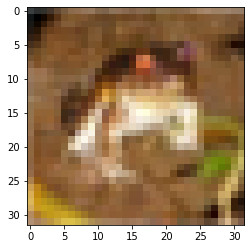

In [2]:
# data loading
cifar_sample = np.load('resources/cifar_sample.npy')
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1,2,0)) 

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [11]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = (2*padding + img_height - filter_size)/stride + 1
    out_width = (2*padding + img_width - filter_size)/stride + 1
    out_channels = filter_channels
    
    # your code here
    steps_per_row = int(out_width)
    steps_per_column = int(out_height)
    output = torch.zeros(n_filters, int(out_height), int(out_width))

    for filter_number in range(n_filters):
        single_output = torch.zeros(int(out_height), int(out_width))
        for col_iteration in range(steps_per_row):
            for row_iteration in range(steps_per_column):
                temp_sum = 0
                for channel in range(filter_channels):
                    print('########## \n image: \n', image[channel,(row_iteration*stride):(row_iteration*stride+filter_size),
                                               (col_iteration*stride):(col_iteration*stride+filter_size)],
                         '\n ######## \n filter: \n', filters[filter_number, channel])
                    temp_sum += torch.sum(torch.mul(image[channel,(row_iteration*stride):(row_iteration*stride+filter_size),
                                               (col_iteration*stride):(col_iteration*stride+filter_size)],
                                                    filters[filter_number, channel]))
                temp_sum += bias[filter_number]
                output[filter_number, row_iteration, col_iteration] = temp_sum
        
            
    return output

In [12]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.randn((2))),
           (torch.randn((2,3,5,5)), torch.randn((2))),
           (torch.randn((5,3,1,1)), torch.randn((5)))]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

########## 
 image: 
 tensor([[0.2314, 0.1686, 0.1961],
        [0.0627, 0.0000, 0.0706],
        [0.0980, 0.0627, 0.1922]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.2431, 0.1804, 0.1882],
        [0.0784, 0.0000, 0.0314],
        [0.0941, 0.0275, 0.1059]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2471, 0.1765, 0.1686],
        [0.0784, 0.0000, 0.0000],
        [0.0824, 0.0000, 0.0314]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.0627, 0.0000, 0.0706],
        [0.0980, 0.0627, 0.1922],
        [0.1294, 0.1490, 0.3412]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660]

########## 
 image: 
 tensor([[0.1608, 0.2000, 0.2078],
        [0.1490, 0.1922, 0.1804],
        [0.1255, 0.1882, 0.1686]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.4980, 0.5059, 0.5059],
        [0.4902, 0.5137, 0.5020],
        [0.5137, 0.5451, 0.5451]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3137, 0.3373, 0.3333],
        [0.2980, 0.3333, 0.3176],
        [0.3137, 0.3490, 0.3412]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.1490, 0.1922, 0.1804],
        [0.1255, 0.1882, 0.1686],
        [0.1373, 0.1804, 0.1725]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982]

 tensor([[0.5294, 0.4980, 0.5059],
        [0.5647, 0.5765, 0.4745],
        [0.5608, 0.5176, 0.3529]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3804, 0.3608, 0.3686],
        [0.4118, 0.4314, 0.3490],
        [0.4000, 0.3608, 0.2314]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2157, 0.2235, 0.2549],
        [0.2510, 0.2902, 0.2549],
        [0.2549, 0.2314, 0.1412]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5647, 0.5765, 0.4745],
        [0.5608, 0.5176, 0.3529],
        [0.5765, 0.5333, 0.3137]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  

########## 
 image: 
 tensor([[0.1412, 0.1569, 0.1529],
        [0.1647, 0.1686, 0.1451],
        [0.1569, 0.1176, 0.1216]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5137, 0.5059, 0.4667],
        [0.5176, 0.4784, 0.4745],
        [0.4980, 0.5412, 0.5373]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3294, 0.3294, 0.3020],
        [0.3255, 0.2902, 0.2902],
        [0.3176, 0.3529, 0.3490]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.1647, 0.1686, 0.1451],
        [0.1569, 0.1176, 0.1216],
        [0.1569, 0.1843, 0.1804]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982]

 tensor([[0.6000, 0.6392, 0.6510],
        [0.5569, 0.5882, 0.6000],
        [0.5412, 0.5647, 0.5569]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.4235, 0.4588, 0.4706],
        [0.3843, 0.4157, 0.4157],
        [0.3686, 0.3922, 0.3725]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2667, 0.3255, 0.3216],
        [0.2078, 0.2196, 0.2275],
        [0.1922, 0.2078, 0.2078]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5569, 0.5882, 0.6000],
        [0.5412, 0.5647, 0.5569],
        [0.5569, 0.6000, 0.5882]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  

 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.7098, 0.9529, 0.5765],
        [0.8863, 0.9529, 0.5255],
        [0.9686, 0.8353, 0.5333]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.5490, 0.8314, 0.4510],
        [0.8314, 0.8980, 0.4078],
        [0.9216, 0.7608, 0.3922]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.9333, 0.9725, 0.6667],
        [0.9882, 0.8980, 0.6784],
        [0.8235, 0.7569, 0.6510]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.8863, 0.9529, 0.5255],
        [0.9686, 0.8353, 0.5333],
        [0.7804, 

 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5137, 0.2902, 0.2118],
        [0.3529, 0.2471, 0.2431],
        [0.3137, 0.3804, 0.3529]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3686, 0.1647, 0.0980],
        [0.2353, 0.1373, 0.1294],
        [0.1569, 0.2078, 0.1765]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2078, 0.0784, 0.0627],
        [0.1176, 0.0353, 0.0627],
        [0.0510, 0.0667, 0.0667]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.3529, 0.2471, 0.2431],
        [0.3137, 0.3804, 0.3529],
        [0.4353, 

 tensor([[0.4510, 0.4392, 0.4118],
        [0.2745, 0.2902, 0.2745],
        [0.2863, 0.3608, 0.3412]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.3569, 0.3373, 0.3098],
        [0.1412, 0.1373, 0.1294],
        [0.1490, 0.1882, 0.1843]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.4118, 0.4431, 0.4275],
        [0.4118, 0.5020, 0.4863],
        [0.4431, 0.5725, 0.5216]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.2745, 0.2902, 0.2745],
        [0.2863, 0.3608, 0.3412],
        [0.3020, 0.4118, 0.3569]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  

########## 
 image: 
 tensor([[0.4118, 0.1843, 0.2275],
        [0.4314, 0.2588, 0.1922],
        [0.3490, 0.2549, 0.2078]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.7451, 0.5961, 0.5608],
        [0.6588, 0.5922, 0.5686],
        [0.8118, 0.5843, 0.5451]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.6000, 0.4235, 0.3725],
        [0.5137, 0.4235, 0.3804],
        [0.6941, 0.4392, 0.3765]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.4314, 0.2588, 0.1922],
        [0.3490, 0.2549, 0.2078],
        [0.5529, 0.2902, 0.2157]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982]

 tensor([[0.7412, 0.8039, 0.8118],
        [0.8588, 0.8941, 0.8824],
        [0.9490, 0.9569, 0.9333]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.5804, 0.6431, 0.6353],
        [0.7529, 0.7373, 0.7373],
        [0.8902, 0.8902, 0.8627]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.3882, 0.4314, 0.4510],
        [0.5843, 0.5020, 0.4706],
        [0.7686, 0.7294, 0.6471]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.8588, 0.8941, 0.8824],
        [0.9490, 0.9569, 0.9333],
        [0.9686, 1.0000, 1.0000]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  

########## 
 image: 
 tensor([[0.2980, 0.2510, 0.3059],
        [0.1294, 0.1059, 0.1804],
        [0.2000, 0.1686, 0.1843]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.4275, 0.4118, 0.4902],
        [0.4784, 0.4510, 0.4706],
        [0.4588, 0.4980, 0.4784]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.2784, 0.2706, 0.3490],
        [0.3333, 0.3098, 0.3333],
        [0.2980, 0.3412, 0.3176]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.1294, 0.1059, 0.1804],
        [0.2000, 0.1686, 0.1843],
        [0.1608, 0.2039, 0.1686]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982]

 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.4196, 0.4353, 0.4275],
        [0.3804, 0.4392, 0.4275],
        [0.3333, 0.3451, 0.3294]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2392, 0.2549, 0.2471],
        [0.2039, 0.2588, 0.2392],
        [0.1686, 0.1686, 0.1451]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5529, 0.6118, 0.6000],
        [0.5098, 0.5176, 0.5020],
        [0.5961, 0.5294, 0.5451]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3804, 0.4392, 0.4275],
        [0.3333, 0.3451, 0.3294],
        [0.4157, 

########## 
 image: 
 tensor([[0.9020, 0.8431, 0.9059],
        [0.7647, 0.5882, 0.8157],
        [0.7451, 0.6667, 0.7020]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.8157, 0.7686, 0.8510],
        [0.7098, 0.5373, 0.7569],
        [0.6706, 0.6157, 0.6549]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.6667, 0.6275, 0.7725],
        [0.5961, 0.3922, 0.6039],
        [0.5333, 0.4118, 0.4118]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.7647, 0.5882, 0.8157],
        [0.7451, 0.6667, 0.7020],
        [0.7216, 0.8471, 0.8314]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660]

 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3882, 0.3647, 0.3373],
        [0.3725, 0.3843, 0.3608],
        [0.2118, 0.2902, 0.3765]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2235, 0.2039, 0.1725],
        [0.2275, 0.2588, 0.2000],
        [0.1412, 0.2824, 0.3098]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5137, 0.5529, 0.5294],
        [0.3451, 0.4627, 0.5490],
        [0.5333, 0.4784, 0.5451]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.3725, 0.3843, 0.3608],
        [0.2118, 0.2902, 0.3765],
        [0.3647, 

########## 
 image: 
 tensor([[0.5608, 0.5451, 0.5333],
        [0.6039, 0.6039, 0.5608],
        [0.5804, 0.5843, 0.5843]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.4118, 0.4235, 0.4392],
        [0.4196, 0.4392, 0.4118],
        [0.4118, 0.4235, 0.4275]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.2588, 0.2431, 0.2039],
        [0.2471, 0.2627, 0.2118],
        [0.2314, 0.2431, 0.2471]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.6039, 0.6039, 0.5608],
        [0.5804, 0.5843, 0.5843],
        [0.5529, 0.5686, 0.5765]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660]

 tensor([[0.5569, 0.4980, 0.5059],
        [0.5216, 0.4549, 0.4510],
        [0.4902, 0.3333, 0.3176]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.3059, 0.2353, 0.2431],
        [0.2784, 0.1686, 0.1333],
        [0.2471, 0.0627, 0.0510]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.6353, 0.5725, 0.5490],
        [0.6510, 0.5333, 0.5255],
        [0.6118, 0.4667, 0.4706]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.5216, 0.4549, 0.4510],
        [0.4902, 0.3333, 0.3176],
        [0.4588, 0.2980, 0.2941]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  

########## 
 image: 
 tensor([[0.1333, 0.0941, 0.0588],
        [0.1412, 0.1137, 0.1451],
        [0.1529, 0.1333, 0.1294]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.4235, 0.3725, 0.3765],
        [0.4471, 0.4118, 0.3961],
        [0.5059, 0.4980, 0.4667]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.2667, 0.2314, 0.2471],
        [0.2980, 0.2706, 0.2588],
        [0.3569, 0.3490, 0.3255]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.1412, 0.1137, 0.1451],
        [0.1529, 0.1333, 0.1294],
        [0.1922, 0.1882, 0.1686]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982]

 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.5294, 0.7412, 0.8275],
        [0.6706, 0.8431, 0.7294],
        [0.7961, 0.8078, 0.4863]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])
########## 
 image: 
 tensor([[0.4000, 0.6235, 0.7098],
        [0.5137, 0.7176, 0.6078],
        [0.6549, 0.6784, 0.3647]]) 
 ######## 
 filter: 
 tensor([[ 1.9022, -0.2966, -0.9988],
        [ 0.2721,  1.8160, -1.1386],
        [ 1.3529,  0.0282, -0.0902]])
########## 
 image: 
 tensor([[0.1725, 0.3412, 0.4471],
        [0.2745, 0.4157, 0.3569],
        [0.4000, 0.4118, 0.1922]]) 
 ######## 
 filter: 
 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.6706, 0.8431, 0.7294],
        [0.7961, 0.8078, 0.4863],
        [0.7294, 

########## 
 image: 
 tensor([[0.5804, 0.5725, 0.5686],
        [0.5843, 0.5608, 0.5647],
        [0.5765, 0.5255, 0.5490]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.4549, 0.3922, 0.3922],
        [0.4510, 0.3725, 0.3804],
        [0.4353, 0.3451, 0.3882]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.3098, 0.2118, 0.2157],
        [0.3098, 0.1922, 0.2000],
        [0.2980, 0.1843, 0.2392]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5843, 0.5608, 0.5647],
        [0.5765, 0.5255, 0.5490],
        [0.5961, 0.4588, 0.4471]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774]

 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3529, 0.3804, 0.3451],
        [0.3569, 0.3412, 0.3176],
        [0.4471, 0.3922, 0.3490]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1843, 0.2078, 0.1882],
        [0.2000, 0.1882, 0.1725],
        [0.3216, 0.2549, 0.2078]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5176, 0.5020, 0.4667],
        [0.6118, 0.5490, 0.4824],
        [0.6118, 0.5765, 0.5216]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3569, 0.3412, 0.3176],
        [0.4471, 0.3922, 0.3490],
        [0.4588, 

########## 
 image: 
 tensor([[0.6157, 0.5725, 0.5294],
        [0.6000, 0.6196, 0.6431],
        [0.5843, 0.6588, 0.7412]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1059, 0.1333, 0.1255],
        [0.0980, 0.1333, 0.1412],
        [0.2627, 0.2667, 0.2980]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.3843, 0.4667, 0.5451],
        [0.3451, 0.4706, 0.5020],
        [0.4314, 0.5059, 0.5098]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.2863, 0.3569, 0.4196],
        [0.2000, 0.3216, 0.3490],
        [0.2824, 0.3608, 0.3647]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920]

########## 
 image: 
 tensor([[0.2000, 0.4314, 0.8039],
        [0.2314, 0.6314, 0.8235],
        [0.2980, 0.3333, 0.4627]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5490, 0.8588, 0.9569],
        [0.6000, 0.5804, 0.6510],
        [0.5922, 0.5020, 0.5333]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.4000, 0.7686, 0.9098],
        [0.4588, 0.4627, 0.5529],
        [0.4353, 0.3569, 0.3804]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2314, 0.6314, 0.8235],
        [0.2980, 0.3333, 0.4627],
        [0.2784, 0.2039, 0.2392]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160]

 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2588, 0.3176, 0.2667],
        [0.1647, 0.2745, 0.2157],
        [0.1294, 0.1725, 0.0902]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.4039, 0.5098, 0.4706],
        [0.3451, 0.4275, 0.3961],
        [0.3176, 0.3294, 0.4196]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.2902, 0.4039, 0.3255],
        [0.2392, 0.3137, 0.2235],
        [0.2039, 0.1843, 0.2157]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1647, 0.2745, 0.2157],
        [0.1294, 0.1725, 0.0902],
        [0.0941, 

 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3098, 0.2745, 0.2627],
        [0.3059, 0.3098, 0.2941],
        [0.3294, 0.3529, 0.2941]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1725, 0.1451, 0.1373],
        [0.1725, 0.1804, 0.1765],
        [0.1765, 0.2078, 0.1569]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.4392, 0.4392, 0.4157],
        [0.4745, 0.4902, 0.4275],
        [0.4902, 0.5059, 0.4157]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3059, 0.3098, 0.2941],
        [0.3294, 0.3529, 0.2941],
        [0.3451, 

 tensor([[0.6706, 0.6471, 0.7647],
        [0.7412, 0.8039, 0.7882],
        [0.7020, 0.8314, 0.7961]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.5255, 0.4510, 0.5804],
        [0.5922, 0.6275, 0.6157],
        [0.5529, 0.6824, 0.6588]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.3882, 0.2706, 0.3882],
        [0.4627, 0.4706, 0.4431],
        [0.4118, 0.5412, 0.5176]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.7412, 0.8039, 0.7882],
        [0.7020, 0.8314, 0.7961],
        [0.6510, 0.7922, 0.8784]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  

########## 
 image: 
 tensor([[0.5373, 0.6196, 0.8471],
        [0.3961, 0.6353, 0.7843],
        [0.4118, 0.6118, 0.6510]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2235, 0.4039, 0.6902],
        [0.2000, 0.4745, 0.6667],
        [0.2471, 0.4392, 0.5294]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5686, 0.7961, 0.8745],
        [0.6353, 0.8078, 0.7686],
        [0.7686, 0.8000, 0.8627]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3961, 0.6353, 0.7843],
        [0.4118, 0.6118, 0.6510],
        [0.5216, 0.6157, 0.7373]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920]

########## 
 image: 
 tensor([[0.2902, 0.2549, 0.2431],
        [0.1686, 0.1608, 0.2000],
        [0.0863, 0.1216, 0.4000]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1333, 0.1059, 0.0824],
        [0.0667, 0.0667, 0.0824],
        [0.0549, 0.0667, 0.2706]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.2667, 0.2902, 0.3961],
        [0.1608, 0.2824, 0.7098],
        [0.1725, 0.3373, 0.7961]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.1686, 0.1608, 0.2000],
        [0.0863, 0.1216, 0.4000],
        [0.1137, 0.1529, 0.4157]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920]

########## 
 image: 
 tensor([[0.5098, 0.5020, 0.5922],
        [0.4980, 0.4941, 0.5451],
        [0.4941, 0.4980, 0.5412]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3451, 0.3412, 0.4235],
        [0.3255, 0.3216, 0.3686],
        [0.3216, 0.3176, 0.3451]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2000, 0.2039, 0.2745],
        [0.1882, 0.2000, 0.2353],
        [0.1922, 0.2000, 0.2039]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.4980, 0.4941, 0.5451],
        [0.4941, 0.4980, 0.5412],
        [0.5333, 0.5373, 0.5804]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774]

 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.8588, 0.7725, 0.7059],
        [0.8431, 0.7882, 0.7529],
        [0.6510, 0.5412, 0.5020]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.9373, 0.9176, 0.9059],
        [0.7882, 0.7216, 0.7098],
        [0.5725, 0.5843, 0.6157]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.9137, 0.8784, 0.8510],
        [0.7294, 0.6392, 0.6196],
        [0.4667, 0.4549, 0.4863]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.8431, 0.7882, 0.7529],
        [0.6510, 0.5412, 0.5020],
        [0.3333, 

########## 
 image: 
 tensor([[0.2667, 0.2510, 0.3216],
        [0.3922, 0.3020, 0.2941],
        [0.4745, 0.3961, 0.3765]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.1569, 0.1490, 0.2078],
        [0.2275, 0.1647, 0.1686],
        [0.2941, 0.2275, 0.2118]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.0902, 0.0667, 0.1176],
        [0.1922, 0.1059, 0.0941],
        [0.2235, 0.1608, 0.1294]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.3922, 0.3020, 0.2941],
        [0.4745, 0.3961, 0.3765],
        [0.5255, 0.5490, 0.6863]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774]

 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2078, 0.1804, 0.2235],
        [0.2353, 0.1412, 0.1608],
        [0.2510, 0.1804, 0.1294]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5843, 0.4863, 0.4941],
        [0.6078, 0.5412, 0.4706],
        [0.5725, 0.5294, 0.4588]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3961, 0.3059, 0.3333],
        [0.4314, 0.3686, 0.2980],
        [0.3647, 0.3294, 0.3137]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2353, 0.1412, 0.1608],
        [0.2510, 0.1804, 0.1294],
        [0.1686, 

########## 
 image: 
 tensor([[0.7961, 0.8235, 0.6627],
        [0.6275, 0.5765, 0.5725],
        [0.2902, 0.2549, 0.2667]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.7922, 0.7451, 0.7765],
        [0.5804, 0.5529, 0.5529],
        [0.5686, 0.5608, 0.5059]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.7176, 0.6706, 0.6863],
        [0.4314, 0.4157, 0.4353],
        [0.4078, 0.4000, 0.3765]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.6275, 0.5765, 0.5725],
        [0.2902, 0.2549, 0.2667],
        [0.2314, 0.2353, 0.1882]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160]

########## 
 image: 
 tensor([[0.2471, 0.3569, 0.3608],
        [0.2627, 0.3529, 0.3412],
        [0.2471, 0.3765, 0.3725]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1255, 0.2078, 0.2078],
        [0.0980, 0.1608, 0.1765],
        [0.0980, 0.2039, 0.2314]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.4235, 0.5294, 0.5137],
        [0.4235, 0.5490, 0.5373],
        [0.4863, 0.5137, 0.5098]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.2627, 0.3529, 0.3412],
        [0.2471, 0.3765, 0.3725],
        [0.3020, 0.3412, 0.3569]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920]

 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.6588, 0.6235, 0.6196],
        [0.5176, 0.5216, 0.5216],
        [0.5098, 0.5569, 0.5098]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.5333, 0.5059, 0.5098],
        [0.3569, 0.3686, 0.3765],
        [0.3608, 0.4118, 0.3686]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.4235, 0.4000, 0.4078],
        [0.2078, 0.2275, 0.2353],
        [0.2078, 0.2667, 0.2275]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5176, 0.5216, 0.5216],
        [0.5098, 0.5569, 0.5098],
        [0.5176, 

 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1333, 0.1686, 0.1961],
        [0.1216, 0.1373, 0.1529],
        [0.0549, 0.0314, 0.0392]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.4353, 0.4745, 0.5059],
        [0.4431, 0.4235, 0.4431],
        [0.4627, 0.3765, 0.4000]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.4353, 0.4627, 0.4549],
        [0.5294, 0.5216, 0.4784],
        [0.5529, 0.4745, 0.4431]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.1216, 0.1373, 0.1529],
        [0.0549, 0.0314, 0.0392],
        [0.0784, 

########## 
 image: 
 tensor([[0.2039, 0.1765, 0.2157],
        [0.2157, 0.1804, 0.2235],
        [0.2000, 0.1804, 0.2196]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160],
        [-0.8229,  1.0994, -0.5122]])
########## 
 image: 
 tensor([[0.5333, 0.5098, 0.5255],
        [0.5216, 0.5176, 0.5216],
        [0.5294, 0.5333, 0.5216]]) 
 ######## 
 filter: 
 tensor([[ 0.3024, -1.0819, -0.7008],
        [-0.0466,  0.7728,  1.9774],
        [-0.1303,  0.4688, -0.2501]])
########## 
 image: 
 tensor([[0.3725, 0.3373, 0.3647],
        [0.3529, 0.3412, 0.3608],
        [0.3569, 0.3490, 0.3569]]) 
 ######## 
 filter: 
 tensor([[ 0.5014,  0.1928,  0.5274],
        [ 1.3528, -0.7350, -1.3920],
        [-0.2751, -0.8745,  2.1250]])
########## 
 image: 
 tensor([[0.2157, 0.1804, 0.2235],
        [0.2000, 0.1804, 0.2196],
        [0.2039, 0.1882, 0.2196]]) 
 ######## 
 filter: 
 tensor([[ 0.7491,  1.6097, -1.5366],
        [-0.0719,  1.5589,  0.8160]

 tensor([[-2.0306, -1.4932, -1.5125],
        [ 2.1184, -1.6559, -0.5982],
        [ 1.1855,  1.0136, -0.4815]])
########## 
 image: 
 tensor([[0.7059, 0.6784, 0.7294],
        [0.6941, 0.6588, 0.7020]]) 
 ######## 
 filter: 
 tensor([[ 1.3645,  1.8194,  0.0349],
        [-0.8428, -0.9807,  0.2660],
        [-0.2808,  1.3950, -0.5530]])


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [13]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = (2*padding + img_height - kernel_size)/stride + 1
    out_width = (2*padding + img_width - kernel_size)/stride + 1
    out_channels = img_channels
    
    steps_per_row = int(out_width)
    steps_per_column = int(out_height)
    output = torch.zeros(int(out_channels), int(out_height), int(out_width))
    # your code here
    for col_iteration in range(steps_per_row):
        for row_iteration in range(steps_per_column):
            for channel in range(out_channels):
                temp = image[channel, (row_iteration*stride):(row_iteration*stride+kernel_size),
                                                                               (col_iteration*stride):(col_iteration*stride+kernel_size)]
                print(temp)
                x = torch.max(temp)
                output[channel, row_iteration, col_iteration] = torch.max(image[channel, 
                                                                                (row_iteration*stride):(row_iteration*stride+kernel_size),
                                                                               (col_iteration*stride):(col_iteration*stride+kernel_size)])

    return output

In [14]:
# Max Pooling Test
from itertools import product

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

tensor([[0.2314, 0.1686],
        [0.0627, 0.0000]])
tensor([[0.2431, 0.1804],
        [0.0784, 0.0000]])
tensor([[0.2471, 0.1765],
        [0.0784, 0.0000]])
tensor([[0.0627, 0.0000],
        [0.0980, 0.0627]])
tensor([[0.0784, 0.0000],
        [0.0941, 0.0275]])
tensor([[0.0784, 0.0000],
        [0.0824, 0.0000]])
tensor([[0.0980, 0.0627],
        [0.1294, 0.1490]])
tensor([[0.0941, 0.0275],
        [0.0980, 0.0784]])
tensor([[0.0824, 0.0000],
        [0.0667, 0.0157]])
tensor([[0.1294, 0.1490],
        [0.1961, 0.2314]])
tensor([[0.0980, 0.0784],
        [0.1255, 0.1255]])
tensor([[0.0667, 0.0157],
        [0.0824, 0.0431]])
tensor([[0.1961, 0.2314],
        [0.2784, 0.3294]])
tensor([[0.1255, 0.1255],
        [0.1882, 0.2078]])
tensor([[0.0824, 0.0431],
        [0.1137, 0.0941]])
tensor([[0.2784, 0.3294],
        [0.3804, 0.4353]])
tensor([[0.1882, 0.2078],
        [0.2706, 0.2941]])
tensor([[0.1137, 0.0941],
        [0.1569, 0.1412]])
tensor([[0.3804, 0.4353],
        [0.4510, 0.4

tensor([[0.5176, 0.5294],
        [0.5098, 0.5490]])
tensor([[0.3490, 0.3725],
        [0.3373, 0.4000]])
tensor([[0.1922, 0.2000],
        [0.1765, 0.2314]])
tensor([[0.5098, 0.5490],
        [0.4824, 0.6000]])
tensor([[0.3373, 0.4000],
        [0.3176, 0.4588]])
tensor([[0.1765, 0.2314],
        [0.1529, 0.2980]])
tensor([[0.4824, 0.6000],
        [0.5412, 0.5922]])
tensor([[0.3176, 0.4588],
        [0.3529, 0.4353]])
tensor([[0.1529, 0.2980],
        [0.1961, 0.2784]])
tensor([[0.5412, 0.5922],
        [0.6275, 0.5882]])
tensor([[0.3529, 0.4353],
        [0.4275, 0.4157]])
tensor([[0.1961, 0.2784],
        [0.2824, 0.2510]])
tensor([[0.6275, 0.5882],
        [0.5882, 0.6000]])
tensor([[0.4275, 0.4157],
        [0.4078, 0.4275]])
tensor([[0.2824, 0.2510],
        [0.2471, 0.2431]])
tensor([[0.5882, 0.6000],
        [0.5294, 0.5451]])
tensor([[0.4078, 0.4275],
        [0.3529, 0.3686]])
tensor([[0.2471, 0.2431],
        [0.1765, 0.1922]])
tensor([[0.5294, 0.5451],
        [0.4784, 0.5

tensor([[0.5176, 0.3529],
        [0.4745, 0.3137]])
tensor([[0.3804, 0.2353],
        [0.3412, 0.1569]])
tensor([[0.2667, 0.1176],
        [0.2667, 0.0510]])
tensor([[0.4745, 0.3137],
        [0.4706, 0.4353]])
tensor([[0.3412, 0.1569],
        [0.3255, 0.2353]])
tensor([[0.2667, 0.0510],
        [0.2157, 0.0549]])
tensor([[0.4706, 0.4353],
        [0.3961, 0.5412]])
tensor([[0.3255, 0.2353],
        [0.2235, 0.3098]])
tensor([[0.2157, 0.0549],
        [0.0902, 0.0745]])
tensor([[0.3961, 0.5412],
        [0.4196, 0.6471]])
tensor([[0.2235, 0.3098],
        [0.2157, 0.4157]])
tensor([[0.0902, 0.0745],
        [0.0980, 0.1961]])
tensor([[0.4196, 0.6471],
        [0.5059, 0.7529]])
tensor([[0.2157, 0.4157],
        [0.3176, 0.5961]])
tensor([[0.0980, 0.1961],
        [0.1765, 0.4431]])
tensor([[0.5059, 0.7529],
        [0.7137, 0.8627]])
tensor([[0.3176, 0.5961],
        [0.5725, 0.7490]])
tensor([[0.1765, 0.4431],
        [0.4314, 0.6627]])
tensor([[0.7137, 0.8627],
        [0.8745, 0.8

tensor([[0.5647, 0.5373],
        [0.5529, 0.5137]])
tensor([[0.3961, 0.3686],
        [0.3961, 0.3490]])
tensor([[0.2235, 0.2118],
        [0.2353, 0.2000]])
tensor([[0.5529, 0.5137],
        [0.5686, 0.5373]])
tensor([[0.3961, 0.3490],
        [0.3882, 0.3569]])
tensor([[0.2353, 0.2000],
        [0.2235, 0.2000]])
tensor([[0.5686, 0.5373],
        [0.5529, 0.5451]])
tensor([[0.3882, 0.3569],
        [0.3647, 0.3569]])
tensor([[0.2235, 0.2000],
        [0.2039, 0.2000]])
tensor([[0.5529, 0.5451],
        [0.6314, 0.6000]])
tensor([[0.3647, 0.3569],
        [0.4824, 0.4471]])
tensor([[0.2039, 0.2000],
        [0.3608, 0.3294]])
tensor([[0.5373, 0.5059],
        [0.4275, 0.4392]])
tensor([[0.4118, 0.3804],
        [0.2745, 0.2824]])
tensor([[0.3098, 0.2784],
        [0.1294, 0.1451]])
tensor([[0.4275, 0.4392],
        [0.4863, 0.5098]])
tensor([[0.2745, 0.2824],
        [0.3412, 0.3608]])
tensor([[0.1294, 0.1451],
        [0.1843, 0.2196]])
tensor([[0.4863, 0.5098],
        [0.5216, 0.4

tensor([[0.5412, 0.5255],
        [0.6941, 0.6314]])
tensor([[0.3216, 0.3333],
        [0.4745, 0.4314]])
tensor([[0.1804, 0.2235],
        [0.3216, 0.2784]])
tensor([[0.6941, 0.6314],
        [0.8353, 0.7490]])
tensor([[0.4745, 0.4314],
        [0.6431, 0.5608]])
tensor([[0.3216, 0.2784],
        [0.4627, 0.3569]])
tensor([[0.8353, 0.7490],
        [0.8392, 0.8471]])
tensor([[0.6431, 0.5608],
        [0.6941, 0.6824]])
tensor([[0.4627, 0.3569],
        [0.4392, 0.4392]])
tensor([[0.8392, 0.8471],
        [0.9451, 0.8902]])
tensor([[0.6941, 0.6824],
        [0.8588, 0.7725]])
tensor([[0.4392, 0.4392],
        [0.6392, 0.5647]])
tensor([[0.9451, 0.8902],
        [0.9608, 0.9255]])
tensor([[0.8588, 0.7725],
        [0.9176, 0.8510]])
tensor([[0.6392, 0.5647],
        [0.7725, 0.7059]])
tensor([[0.9608, 0.9255],
        [0.9176, 0.9059]])
tensor([[0.9176, 0.8510],
        [0.8784, 0.8510]])
tensor([[0.7725, 0.7059],
        [0.7882, 0.7529]])
tensor([[0.9176, 0.9059],
        [0.7216, 0.7

tensor([[0.1490, 0.1333],
        [0.0549, 0.0980]])
tensor([[0.3020, 0.3098],
        [0.5294, 0.5608]])
tensor([[0.1686, 0.1961],
        [0.3608, 0.4118]])
tensor([[0.0549, 0.0980],
        [0.2039, 0.2588]])
tensor([[0.5294, 0.5608],
        [0.6314, 0.6039]])
tensor([[0.3608, 0.4118],
        [0.4431, 0.4196]])
tensor([[0.2039, 0.2588],
        [0.2549, 0.2471]])
tensor([[0.6314, 0.6039],
        [0.5765, 0.5804]])
tensor([[0.4431, 0.4196],
        [0.4039, 0.4118]])
tensor([[0.2549, 0.2471],
        [0.2235, 0.2314]])
tensor([[0.5765, 0.5804],
        [0.4941, 0.5529]])
tensor([[0.4039, 0.4118],
        [0.3333, 0.3961]])
tensor([[0.2235, 0.2314],
        [0.1608, 0.2157]])
tensor([[0.4941, 0.5529],
        [0.4706, 0.5020]])
tensor([[0.3333, 0.3961],
        [0.2980, 0.3294]])
tensor([[0.1608, 0.2157],
        [0.1294, 0.1529]])
tensor([[0.4706, 0.5020],
        [0.4588, 0.4392]])
tensor([[0.2980, 0.3294],
        [0.3137, 0.2824]])
tensor([[0.1294, 0.1529],
        [0.1490, 0.1

tensor([[0.4235, 0.3725],
        [0.4471, 0.4118]])
tensor([[0.2667, 0.2314],
        [0.2980, 0.2706]])
tensor([[0.1412, 0.1137],
        [0.1529, 0.1333]])
tensor([[0.4471, 0.4118],
        [0.5059, 0.4980]])
tensor([[0.2980, 0.2706],
        [0.3569, 0.3490]])
tensor([[0.1529, 0.1333],
        [0.1922, 0.1882]])
tensor([[0.5059, 0.4980],
        [0.5255, 0.5216]])
tensor([[0.3569, 0.3490],
        [0.3647, 0.3647]])
tensor([[0.1922, 0.1882],
        [0.1961, 0.2039]])
tensor([[0.5255, 0.5216],
        [0.5216, 0.5412]])
tensor([[0.3647, 0.3647],
        [0.3569, 0.3804]])
tensor([[0.1961, 0.2039],
        [0.2000, 0.2235]])
tensor([[0.5216, 0.5412],
        [0.5176, 0.5333]])
tensor([[0.3569, 0.3804],
        [0.3647, 0.3725]])
tensor([[0.2000, 0.2235],
        [0.2196, 0.2235]])
tensor([[0.5176, 0.5333],
        [0.5137, 0.5255]])
tensor([[0.3647, 0.3725],
        [0.3647, 0.3647]])
tensor([[0.2196, 0.2235],
        [0.2353, 0.2235]])
tensor([[0.5137, 0.5255],
        [0.4941, 0.5

tensor([[0.4510, 0.3725],
        [0.4353, 0.3451]])
tensor([[0.3098, 0.1922],
        [0.2980, 0.1843]])
tensor([[0.5765, 0.5255],
        [0.5961, 0.4588]])
tensor([[0.4353, 0.3451],
        [0.4471, 0.2941]])
tensor([[0.2980, 0.1843],
        [0.3137, 0.1451]])
tensor([[0.5961, 0.4588],
        [0.5686, 0.4980]])
tensor([[0.4471, 0.2941],
        [0.4118, 0.3216]])
tensor([[0.3137, 0.1451],
        [0.2824, 0.1608]])
tensor([[0.5686, 0.4980],
        [0.5608, 0.4980]])
tensor([[0.4118, 0.3216],
        [0.4078, 0.3137]])
tensor([[0.2824, 0.1608],
        [0.2588, 0.1490]])
tensor([[0.5608, 0.4980],
        [0.5608, 0.4902]])
tensor([[0.4078, 0.3137],
        [0.4078, 0.2980]])
tensor([[0.2588, 0.1490],
        [0.2510, 0.1255]])
tensor([[0.5608, 0.4902],
        [0.5529, 0.5137]])
tensor([[0.4078, 0.2980],
        [0.4000, 0.3137]])
tensor([[0.2510, 0.1255],
        [0.2549, 0.1373]])
tensor([[0.5529, 0.5137],
        [0.5608, 0.5451]])
tensor([[0.4000, 0.3137],
        [0.4039, 0.3

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.